In [2]:
# Import required modules
import numpy as np
import math
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
from bs4.element import Tag
import pprint

In [3]:
# Create a variable with the URL to this tutorial
url = 'http://www.englishforum.ch/forum.php'
# Scrape the HTML at the url
r = requests.get(url)
# Turn the HTML into a Beautiful Soup object
soup = BeautifulSoup(r.text, 'lxml')

In [42]:
# Create four variables to score the scraped data in
dataframes={}
for link in soup.find_all("strong")[1:]:
    for linkhref in soup.find_all("a"):
        if(link in linkhref and not linkhref['href'].endswith('.html') and link.contents[0] not in dataframes):
            dataframes[link.contents[0]]=linkhref['href']
dataframes


{'Business & entrepreneur': 'http://www.englishforum.ch/business-entrepreneur/',
 'Commercial events': 'http://www.englishforum.ch/commercial-events/',
 'Complaints corner': 'http://www.englishforum.ch/complaints-corner/',
 'Concerts': 'http://www.englishforum.ch/concerts/',
 'Daily life': 'http://www.englishforum.ch/daily-life/',
 'Education': 'http://www.englishforum.ch/education/',
 'Employment': 'http://www.englishforum.ch/employment/',
 'Entertainment & dining': 'http://www.englishforum.ch/entertainment-dining/',
 'Family matters/health': 'http://www.englishforum.ch/family-matters-health/',
 'Finance/banking/taxation': 'http://www.englishforum.ch/finance-banking-taxation/',
 'Food and drink': 'http://www.englishforum.ch/food-drink/',
 'Housing in general': 'http://www.englishforum.ch/housing-general/',
 'Insurance': 'http://www.englishforum.ch/insurance/',
 'Introductions': 'http://www.englishforum.ch/introductions/',
 'Language corner': 'http://www.englishforum.ch/language-corner

# Fetch the info from urls

In [138]:
def comments(numPag,thread):
    # Scrape the HTML at the url
    response = requests.get(thread,headers={'Accept':'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8'})
    # Turn the HTML into a Beautiful Soup object
    soup = BeautifulSoup(response.text, 'lxml')
    comments={}
    inception={}
    date=''
    first=[]
    user_and_rep=[]
    for link in soup.find_all("div",{"align":"center"}):
        for link2 in link.find_all("div",{"align":"left"}):
            for link3 in link2.find_all("tr"):
                for link4 in link3.find_all("td",{"width":"99%"}):
                    for link5 in link4.find_all("div"):
                        if('id' in link5.attrs and 'posts' in link5['id']):
                            link6=link5.find('table')
#                             print(link6)
                            link7=link6.find('td').find_all('div')
                            date=link7[-1].contents[-1].strip(' \n\r\t')
                            if(numPag==0):
                                for ind,link7 in enumerate(link6.find_all('div')):
#                                 print(link7.contents[0])
                                    if('href' not in link7 and len(link7.contents)>0):
#                                         print('aaa',ind,type(link7.contents[0]),link7.contents[0])
                                        if(type(link7.contents[0])==Tag):
#                                         link7=link7.find('span')
                                            if(len(link7.attrs)==0):
#                                             print('aaa',ind,type(link7.contents[0]),link7.attrs,link7.contents[0])
                                                user_and_rep=str(link7.contents[0]).partition('img alt="')[2].partition('"')[0]
                                                if('has' in user_and_rep):
                                                    user_and_rep=user_and_rep.partition(' has ')
                                                elif('is' in user_and_rep):
                                                    user_and_rep=user_and_rep.partition(' is ')
                                                user_and_rep=[user_and_rep[0],user_and_rep[2]]
#                                         print(user_and_rep)
                                        else:
                                            stat=link7.contents[0].strip('\n\r\t')
#                                         if(stat!=' ' and ord(stat)!=160):
                                            if(len(stat)>1 and ord(stat[0])!=160):
#                                             print(link7)
                                                first.append(stat)
#                             if(len(user_and_rep)>0):
                        if('id' in link5.attrs and link5['id'].startswith('post_message')):
#                             print(link5.attrs,link5.contents)
                            contents=''
                            for content in link5.contents:
                                if type(content) is not Tag:
                                    contents+=' '+content
#                                 comments[link5['id']]=content
                                elif(str(content).startswith('<font')):
                                    contents+=' '+re.sub(r'<.*?>', '', str(content))
                                
                            comments[link5['id']]=contents
    retcomments=''
    for ind,i in enumerate(sorted(comments)):
#          print(comments[i])
        if(numPag==0):
#             print(user_and_rep,'len',len(first),first)
            if(len(first)==6):
                first.append(comments[i])
            else:
                first[-1]=comments[i]
        retcomments+=comments[i]
    if(numPag==0):
        inception['user']=user_and_rep[0]
        inception['date']=date
        inception['reputation']=user_and_rep[1]
        inception['exp']=first[0]
        inception['since']=first[1]
        inception['location']=first[2]
        inception['posts']=first[3]
        inception['thanked']=first[4]
        inception['groaned']=first[5]
        inception['post']=first[6]
    return [retcomments,inception]

def page(url,index):
#     print(url,index)
    # Scrape the HTML at the url
    r = requests.get(url)    
    # Turn the HTML into a Beautiful Soup object
    soup = BeautifulSoup(r.text, 'lxml')
    subtopic={}
    for link in soup.find_all("table",id="threadslist"):
#         print(link)
        index_aux=index
        dash=0
        for replies in link.find_all("td",class_="alt1"):
            if(replies.contents[0]!=' ' and type(replies.contents[0])!=Tag):
                if(replies.contents[0]=='-'):
                    dash+=1
                subtopic[index_aux]=[]
                subtopic[index_aux].append(replies.contents[0])
# #                 print('rep',index_aux,replies.contents[0])

                index_aux+=1
    
#         print('Replies found:',index_aux)
        index_aux=index
        insertdash=0
        # \xa0 Unicode --> ascii 160
        for views in link.find_all("td",class_="alt2"):
            if('align' in views.attrs and views.contents[0]!=' ' and ord(views.contents[0][0])!=160 and type(views.contents[0])!=Tag):
                if(views.contents[0]=='-'):
                    if(insertdash==0):
                        insertdash=1
                    else:
                        insertdash=0
                        subtopic[index_aux].append(views.contents[0])
                        index_aux+=1
                else:
                    subtopic[index_aux].append(views.contents[0])
                    index_aux+=1    
#         print('Views found:',index_aux)
        for thread in link.find_all("a"):
            if('id' in thread.attrs):
#                 print('hrefs',index,link1.contents[0])
                    subtopic[index].append(thread['href'])
                    subtopic[index].append(thread.contents[0])
                    index+=1
        
#         print('Threads found:',index)
    return [subtopic,index]
    
    
def findAllPages(rootHTML):
    # Scrape the HTML at the url
    r = requests.get(rootHTML)    
    # Turn the HTML into a Beautiful Soup object
    soup = BeautifulSoup(r.text, 'lxml')
    lastUrl=''
    pages=[]
    pages.append(rootHTML)
    for link in soup.find_all("body"):
        for link1 in link.find_all("a"):
            if('title' in link1.attrs and 'Last' in link1['title']):
                lastUrl=link1['href']
                print(link1['href'])
                break
    if(lastUrl==''):#no Last page link, we fetch last index page
        links=set()
        for link in soup.find_all("body"):
            for link1 in link.find_all("a"):
                if('title' in link1.attrs and 'Show results' in link1['title']):
                    links.add(link1['href'])
#                     print(link1)
        if(links!=set() and rootHTML!=sorted(links)[-1]):
            lastUrl=sorted(links)[-1]
    if(lastUrl!=''):
        if(rootHTML.endswith('.html')):
            limit=re.findall(r'\d+',lastUrl)[-1]
            for i in range(2,int(limit)):
                pages.append(re.sub(r'.html','',rootHTML)+"-"+str(i)+".html")
        else:
            limit=re.findall(r'\d+',lastUrl)[0]
            for i in range(2,int(limit)):
                pages.append(rootHTML+"index"+str(i)+".html")
        pages.append(lastUrl)
        return pages
    return pages
    
def createDF(url):
#     print(url)
    index=0
    allsubtopics={}
    nextPages=findAllPages(url)
    for url in nextPages:
#         print('urlllll',url)
        result=page(url,index)
        allsubtopics.update(result[0])
        index=result[1]
    #         print('fin',subtopic)
    replies=[]
    views=[]
    hrefs=[]
    threads=[]
    first_posts=[]
    for value in allsubtopics.values():
        replies.append(value[0])
        views.append(value[1])
        hrefs.append(value[2])
        threads.append(value[3])
    posts=[]
    for href in hrefs:
        nextPages=findAllPages(href)
        threadPosts=[]
        for numPag,pag in enumerate(nextPages):
            if(numPag==0):
                print(pag)
#             threadPosts.append(comments(pag))
            comments_call=comments(numPag,pag)
            threadPosts.append(comments_call[0])
            if(numPag==0):
                first_posts.append(comments_call[1])
        posts.append(''.join(threadPosts))
    date=[]
    exp=[]
    groaned=[]
    location=[]
    post=[]
    user_posts=[]
    reputation=[]
    since=[]
    thanked=[]
    user=[]
#     example of element first_posts
#   {'date': '19.12.2014',
#   'exp': 'Newbie',
#   'groaned': 'Thanked 0 Times in 0 Posts',
#   'location': 'Location: Basel',
#   'post': "Hi all. new to this site, i've been in basel for about 6 months now and was wondering about where and how i can buy e-cigarettes. i've heard they help people quit smoking and i read they are much cheaper too.",
#   'posts': 'Posts: 6',
#   'reputation': 'has made some interesting contributions',
#   'since': 'Join Date: Dec 2014',
#   'thanked': 'Groaned at 1 Time in 1 Post',
#   'user': 'WisePotato'}]
    for stat in first_posts:
        date.append(stat['date'])
        exp.append(stat['exp'])
        groaned.append(stat['groaned'])
        location.append(stat['location'])
        post.append(stat['post'])
        user_posts.append(stat['posts'])
        reputation.append(stat['reputation'])
        since.append(stat['since'])
        thanked.append(stat['thanked'])
        user.append(stat['user'])
    df = pd.DataFrame({'replies': replies, 'views': views, 'hrefs': hrefs, 'threads' : threads, 'posts': posts})
    firstDF=pd.DataFrame({'thread':threads,'date':date,'exp':exp,'groaned':groaned,'location':location,'post':post,'user_posts':user_posts,'reputation':reputation,'since':since,'thanked':thanked})

    return [df,firstDF]

# Save the data into csv folder and remove dataframe

In [43]:
def saveData(dataframe):
    dataframe.to_csv("csv/"+i.replace("/","")+".csv", sep='\t', encoding='utf-8',)
    del dataframe

# Dataframes we'd like to fetch

In [6]:
# for i in dataframes:
for index,i in enumerate(sorted(dataframes)):
    print(index,i,dataframes[i])

0 Business & entrepreneur http://www.englishforum.ch/business-entrepreneur/
1 Commercial events http://www.englishforum.ch/commercial-events/
2 Complaints corner http://www.englishforum.ch/complaints-corner/
3 Concerts http://www.englishforum.ch/concerts/
4 Daily life http://www.englishforum.ch/daily-life/
5 Education http://www.englishforum.ch/education/
6 Employment http://www.englishforum.ch/employment/
7 Entertainment & dining http://www.englishforum.ch/entertainment-dining/
8 Family matters/health http://www.englishforum.ch/family-matters-health/
9 Finance/banking/taxation http://www.englishforum.ch/finance-banking-taxation/
10 Food and drink http://www.englishforum.ch/food-drink/
11 Housing in general http://www.englishforum.ch/housing-general/
12 Insurance http://www.englishforum.ch/insurance/
13 Introductions http://www.englishforum.ch/introductions/
14 Language corner http://www.englishforum.ch/language-corner/
15 Leaving Switzerland http://www.englishforum.ch/leaving-switzerl

# In order to read from csv files

In [7]:
def readData(filename):
    if( not filename.endswith('.csv')):
        filename+='.csv'
    df = pd.read_csv('csv/'+filename, header=0,sep='\t',index_col=0)
    return df

# CSV files we have got so far

In [8]:
import os
for index,i in enumerate(sorted(os.listdir("csv/"))):
    print(index,i)

0 Business & entrepreneur.csv
1 Commercial events.csv
2 Complaints corner.csv
3 Concerts.csv
4 Daily life.csv
5 Education.csv
6 Employment.csv
7 Entertainment & dining.csv
8 Family mattershealth.csv
9 Financebankingtaxation.csv
10 Food and drink.csv
11 Housing in general.csv


# In case we'd like to update the files, let's declare the variables

In [44]:
business_enterpreteur=None
complaints_corner=None
concerts=None
daily_life=None
employment=None
entertainment_dining=None
family_matters_health=None
finance_banking_taxation=None
food_drink=None
housing=None
insurance=None
introductions=None
language_corner=None
leaving_switzerland=None
market_place=None
off_topic=None
other_general=None
permits_visas_gov=None
pet_corner=None
sports_wellness=None
support=None
swiss_politics_news=None
transportation_driving=None
travel_free_time=None
tv_internet_telephone=None
# NON FETCHED BUT YET TO COME
commercial_events=None
education=None
social_events=None
swiss_news=None

# Let's initialize them

In [100]:
for index,i in enumerate(sorted(dataframes)):
    print(index, dataframes[i])
#     df=createDF(dataframes[i][0])
#     saveData(df)
#     if index==0:
#         createDFRet=createDF(dataframes[i])
#         business_enterpreteur=createRet[0]
#         saveData(business_enterpreteur)
#         saveData(createRet[1])
        
# #         business_enterpreteur=createDF(dataframes[i][0])
# #         saveData(business_enterpreteur)
#     elif index==1: 
#         commercial_events=createDF(dataframes[i])#####OK
#         saveData(commercial_events)
# #     elif index==2: m=1
# #         complaints_corner=createDF(dataframes[i])   
# #         saveData(complaints_corner)
# #     elif index==3: m=1
# #         concerts=createDF(dataframes[i])
# #         saveData(concerts)        
#     elif index==4: m=1
# #         daily_life=createDF(dataframes[i])
# #         saveData(daily_life)
# #     elif index==5: 
    if index==5:
        createDFRet=createDF(dataframes[i]) 
        education=createDFRet[0]#####OK
        firsts=createRef[1]
# #     elif index==6: 
# #         employment=createDF(dataframes[i])
# #         saveData(employment)
#     elif index==7: 
# #         entertainment_dining=createDF(dataframes[i])
# #         saveData(entertainment_dining)
#     elif index==8: 
# #         family_matters_health=createDF(dataframes[i])
# #         saveData(family_matters_health)
#     elif index==9: 
# #         finance_banking_taxation=createDF(dataframes[i])
# #         saveData(finance_banking_taxation)
#     elif index==10: 
# #         food_drink=createDF(dataframes[i])
# #         saveData(food_drink)
#     elif index==11: 
# #         housing=createDF(dataframes[i])
# #         saveData(housing)
#     elif index==12: 
#         insurance=createDF(dataframes[i])
#         saveData(insurance)
#     elif index==13: 
#         introductions=createDF(dataframes[i])
#         saveData(introductions)
#     elif index==14: 
#         language_corner=createDF(dataframes[i])
#         saveData(language_corner)
#     elif index==15: 
#         leaving_switzerland=createDF(dataframes[i])
#         saveData(leaving_switzerland)
#     elif index==16: 
#         market_place=createDF(dataframes[i])
#         saveData(market_place)
#     elif index==17: 
#         off_topic=createDF(dataframes[i])
#         saveData(off_topic)
#     elif index==18: 
#         other_general=createDF(dataframes[i])
#         saveData(other_general)
#     elif index==19: 
#         permits_visas_gov=createDF(dataframes[i])
#         saveData(permits_visas_gov)
#     elif index==20: 
#         pet_corner=createDF(dataframes[i])
#         saveData(pet_corner)
#     elif index==21: 
#         social_events=createDF(dataframes[i])#####OK
#         saveData(social_events)
#     elif index==22: 
#         sports_wellness=createDF(dataframes[i])
#         saveData(sports_wellness)
#     elif index==23: 
#         support=createDF(dataframes[i])
#         saveData(support)
#     elif index==24: 
#         swiss_news=createDF(dataframes[i])######
#         saveData(swiss_news)
#     elif index==25: 
#         swiss_politics_news=createDF(dataframes[i])
#         saveData(swiss_politics_news)
#     elif index==26: 
#         tv_internet_telephone=createDF(dataframes[i])
#         saveData(tv_internet_telephone)
#     elif index==27: 
#         transportation_driving=createDF(dataframes[i])
#         saveData(transportation_driving)
#     else: 
#         travel_free_time=createDF(dataframes[i])
#         saveData(travel_free_time)

0 http://www.englishforum.ch/business-entrepreneur/
1 http://www.englishforum.ch/commercial-events/
2 http://www.englishforum.ch/complaints-corner/
3 http://www.englishforum.ch/concerts/
4 http://www.englishforum.ch/daily-life/
5 http://www.englishforum.ch/education/
http://www.englishforum.ch/education/index45.html
http://www.englishforum.ch/education/264368-camp-suisse-adventure-language-summer-camps-school-trips.html
http://www.englishforum.ch/education/49382-childcare-schooling-switzerland-7.html
http://www.englishforum.ch/education/49382-childcare-schooling-switzerland.html
http://www.englishforum.ch/education/222863-academia-international-school-pre-school-primary-school-precollege-college.html
http://www.englishforum.ch/education/167521-read-about-posting-education-forum.html
http://www.englishforum.ch/education/107401-swiss-school-system.html
http://www.englishforum.ch/education/263948-school-7-years-old-around-psi.html
http://www.englishforum.ch/education/264565-university-fun

IndexError: list index out of range

# Load all data at once

In [11]:
import glob
dfContainer={}#sorted(dataframes)
filenames = glob.glob("csv/*.csv")
for index,filename in enumerate(filenames):
    df = pd.read_csv(filename, header=0,sep='\t',index_col=0)
    dfContainer[re.sub(r'.csv','',os.path.basename(filename))]=df
# Casting views from str to int (- to 0 because is a moved)
for key in dfContainer:
    dfContainer[key].views=dfContainer[key].apply(lambda x: int(x[4].replace(',','').replace('-','0')),axis=1)
    dfContainer[key].replies=dfContainer[key].apply(lambda x: int(str(x[2]).replace(',','').replace('-','0')),axis=1)

# sorted(dataframes)
# dataFrames = pd.Series(dataFrames)
# df=pd.read_csv('Concerts',sep='\t',index_col=0)
# df

# dfContainer

## Ideas
- Buscar comentarios más positivos y encontrar los threads de más interes

- con los threads más visitados podemos obtener los topics de más interes
- los usuarios que más aportan en el foro
- los temas más polemicos (tal vez usando los comentarios negativos)
- En un apartado de ventas que hay, intentar sacar lo que se vende en suiza y en donde (aunque el donde no lo tengo muy claro)
- las horas de más publicaciones
- lodgement: tal vez podemos aplicar ML como un clasificador de oportunidades de encontrar casa en suiza

In [12]:
moreViews=pd.DataFrame()
Views=pd.DataFrame()
viewsStats=pd.DataFrame()
repliesStats=pd.DataFrame()
for key in dfContainer:
#     dfContainer[key].views=dfContainer[key].apply(lambda x: int(x[4].replace(',','').replace('-','0')),axis=1)
    viewsStats[key]=dfContainer[key].describe()['views']
    repliesStats[key]=dfContainer[key].describe()['replies']
    temp=dfContainer[key][['threads','views']]
    temp2=temp.sort_values('views',ascending=0)[:4]['views']
    temp2.index=[np.arange(4)]
    Views[key]=temp2
    temp=temp.sort_values('views',ascending=0)[:4]
    temp['index2']=key
    temp.index=[temp.index2,temp.threads]
    temp=temp.drop(['index2','threads'],1)
    moreViews=moreViews.append(temp)


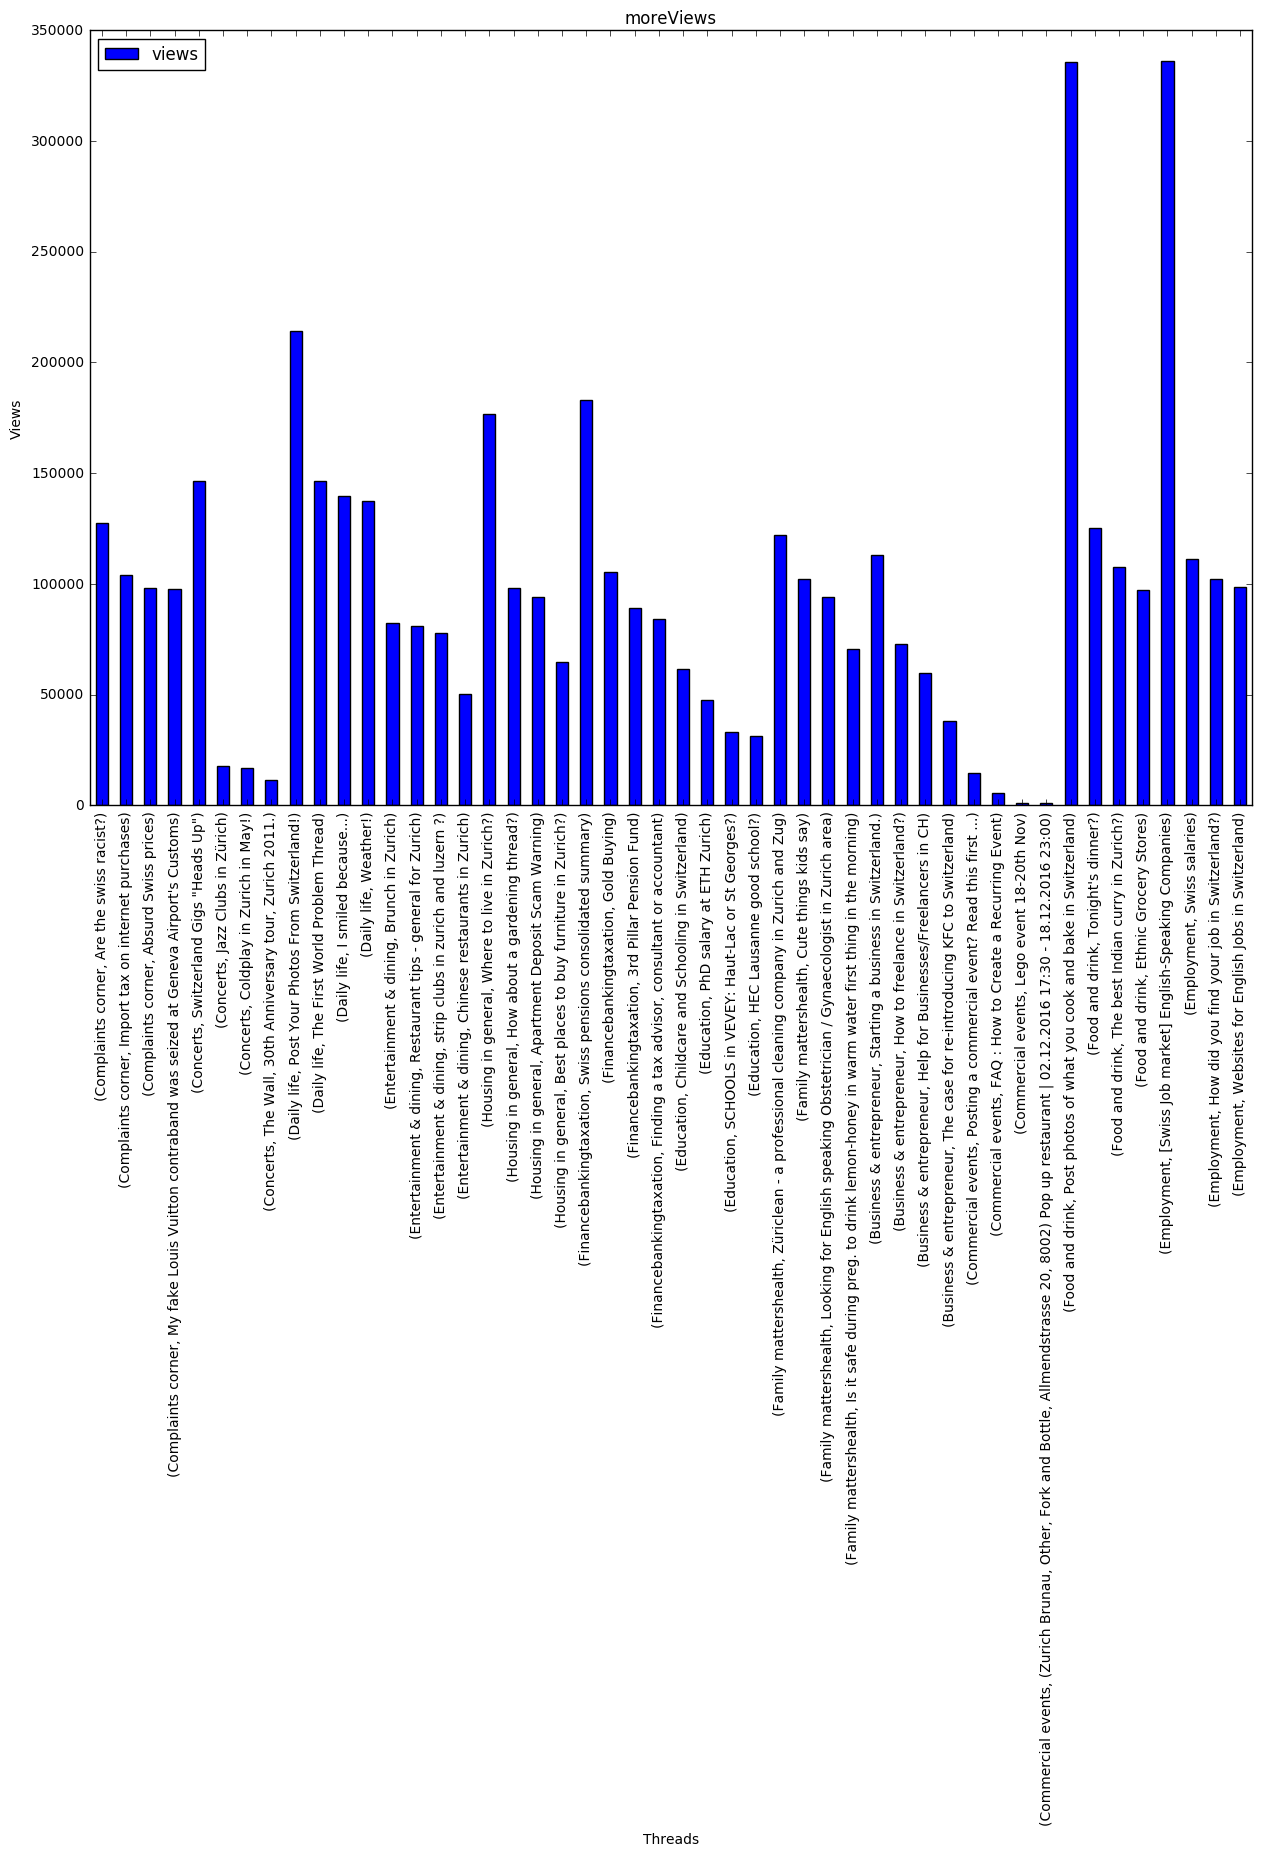

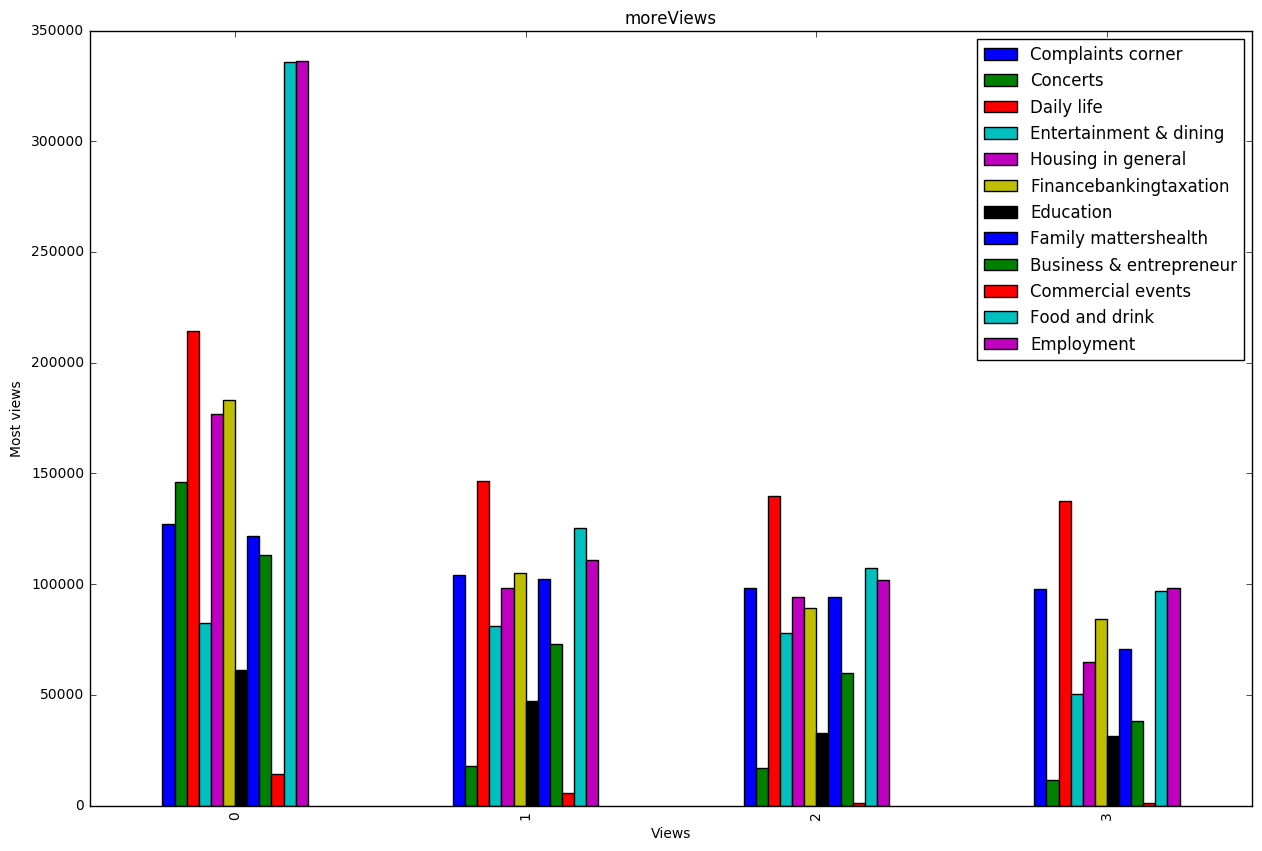

views
index2                  threads                                                   
Complaints corner       Are the swiss racist?                               127300
                        Import tax on internet purchases                    104168
                        Absurd Swiss prices                                  98163
                        My fake Louis Vuitton contraband was seized at ...   97786
Concerts                Switzerland Gigs "Heads Up"                         146316
                        Jazz Clubs in Zürich                                 17853
                        Coldplay in Zurich in May!                           17014
                        The Wall, 30th Anniversary tour, Zurich 2011.        11448
Daily life              Post Your Photos From Switzerland!                  214188
                        The First World Problem Thread                      146459
                        I smiled because...                                 139842
                        Weather!                                            137383
Entertainment & dining  Brunch in Zurich                                     82272
                        Restaurant tips - general for Zurich                 81057
                        strip clubs in zurich and luzern ?                   77828
                        Chinese restaurants in Zurich                        50415
Housing in general      Where to live in Zurich?                            176737
                        How about a gardening thread?                        98330
                        Apartment Deposit Scam Warning                       94154
                        Best places to buy furniture in Zurich?              64705
Financebankingtaxation  Swiss pensions consolidated summary                 183135
                        Gold Buying                                         105254
                        3rd Pillar Pension Fund                              89279
                        Finding a tax advisor, consultant or accountant      84211
Education               Childcare and Schooling in Switzerland               61425
                        PhD salary at ETH Zurich                             47472
                        SCHOOLS in VEVEY: Haut-Lac or St Georges?            32953
                        HEC Lausanne good school?                            31372
Family mattershealth    Züriclean - a professional cleaning company in ...  121963
                        Cute things kids say                                102340
                        Looking for English speaking Obstetrician / Gyn...   94268
                        Is it safe during preg. to drink lemon-honey in...   70706
Business & entrepreneur Starting a business in Switzerland.                 113086
                        How to freelance in Switzerland?                     72965
                        Help for Businesses/Freelancers in CH                59734
                        The case for re-introducing KFC to Switzerland       38135
Commercial events       Posting a commercial event? Read this first ...      14438
                        FAQ : How to Create a Recurring Event                 5555
                        Lego event 18-20th Nov                                1201
                        (Zurich Brunau, Other, Fork and Bottle, Allmend...    1008
Food and drink          Post photos of what you cook and bake in Switze...  335623
                        Tonight's dinner?                                   125354
                        The best Indian curry in Zurich?                    107525
                        Ethnic Grocery Stores                                97135
Employment              [Swiss Job market] English-Speaking Companies       336099
                        Swiss salaries                                      111090
                        How did you find your job in Switzerland?           102092
          

In [13]:
# temp=dfContainer['Business & entrepreneur'][['threads','views']]
# temp=temp.sort_values('views',ascending=0)
# temp2=temp[:3].append(temp[3:4])
# temp2['index2']='a'
# temp2.index=[temp2.index2,np.arange(4)]
# temp2.drop('index2',1)
# temp3=temp[4:8]
# temp3['index2']='b'
# temp3.index=[temp3.index2,np.arange(4)]
# temp2.append(temp3)
moreViews.plot.bar(figsize=(15,10))
plt.title('moreViews')
plt.xlabel('Threads')
plt.ylabel('Views')
Views.plot(kind='bar',figsize=(15,10))
plt.title('moreViews')
plt.xlabel('Views')
plt.ylabel('Most views')
plt.show()
Views
moreViews

In [13]:
viewsStats

,Housing in general,Financebankingtaxation,Food and drink,Employment,Daily life,Education,Complaints corner,Commercial events,Business & entrepreneur,Concerts,Entertainment & dining,Family mattershealth
count,8081.000000,5762.000000,4247.000000,6197.000000,11367.000000,1335.000000,3051.000000,51.000000,2115.000000,848.000000,1728.000000,7278.000000
mean,2154.908675,2799.541305,3318.414410,2867.982249,3137.700713,1830.316105,4409.310062,783.372549,2268.445390,1582.204009,3300.082755,2702.475543
std,3706.396312,5008.214045,7029.252026,6432.127073,5893.594325,2975.504721,6702.763767,2088.857869,3842.561636,5135.194461,5268.870024,4071.669171
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,129.000000,0.000000,0.000000,0.000000,0.000000
25%,936.000000,1039.250000,1166.500000,1040.000000,941.000000,813.000000,1496.000000,264.000000,1033.000000,896.500000,1136.750000,982.250000
50%,1362.000000,1635.000000,2018.000000,1611.000000,1640.000000,1197.000000,2661.000000,388.000000,1477.000000,1133.500000,1791.000000,1643.500000
75%,2263.000000,2875.000000,3708.000000,2874.000000,3299.500000,1847.500000,5065.000000,504.000000,2414.000000,1492.250000,3378.000000,2985.000000
max,176737.000000,183135.000000,335623.000000,336099.000000,214188.000000,61425.000000,127300.000000,14438.000000,113086.000000,146316.000000,82272.000000,121963.000000


In [14]:

repliesStats

,Housing in general,Financebankingtaxation,Food and drink,Employment,Daily life,Education,Complaints corner,Commercial events,Business & entrepreneur,Concerts,Entertainment & dining,Family mattershealth
count,8081.000000,5762.000000,4247.000000,6197.000000,11367.000000,1335.000000,3051.000000,51.000000,2115.000000,848.000000,1728.000000,7278.000000
mean,10.055315,11.767268,19.393219,11.848959,23.017067,9.096629,48.810554,2.039216,9.907329,5.172170,10.791667,14.820555
std,21.645010,27.005078,58.309788,19.083566,58.710651,15.902687,88.912918,4.395274,24.539619,38.641312,21.561710,31.369842
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,2.000000,4.000000,2.000000,3.000000,2.000000,11.000000,0.000000,2.000000,0.000000,1.000000,2.000000
50%,5.000000,6.000000,9.000000,6.000000,9.000000,4.000000,26.000000,0.000000,5.000000,1.000000,4.000000,6.000000
75%,12.000000,13.000000,22.000000,14.000000,24.000000,10.000000,57.000000,2.000000,11.000000,4.000000,11.000000,15.000000
max,1278.000000,1126.000000,2762.000000,453.000000,2555.000000,280.000000,2000.000000,22.000000,770.000000,1100.000000,320.000000,1012.000000


In [14]:
import pickle
def save_obj(obj, name ):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [15]:

from wordcloud import WordCloud, STOPWORDS
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk as nltk
stop = set(stopwords.words('english'))
stop.update([".",",","?",")","(",":","/","!","%","-",""])
stop.update(STOPWORDS)

In [183]:

from sklearn.feature_extraction.text import CountVectorizer
wnl = WordNetLemmatizer()
forumTextContainer={}
i=0
for key in dfContainer:
    temp=dfContainer[key]
    lista=[]
    print(i)
    print("There are %s null values" %temp.isnull().values.sum())
    temp=temp.dropna()
    for thread in (temp.values):
        allwords=[]
#         if not type(thread[1])==float: # moved thread or privated
        text_tk = nltk.word_tokenize(thread[1]) 
        word_tag_fd = nltk.pos_tag(text_tk,tagset='universal') # for simplifying the task, we will une the universal tagset
        for wt in word_tag_fd:
            if  (wt[0] not in stop) and (wt[1] == 'NOUN' or wt[1] == 'ADJ'):
                allwords.append(wnl.lemmatize(wt[0]))
            elif (wt[0] not in stop) and (wt[1] == 'VERB'):
                allwords.append(wnl.lemmatize(wt[0],'v'))
                        
#         allwords=[wnl.lemmatize(wt[0]) for wt in word_tag_fd if  (wt[0] not in stop) and (wt[1] == 'NOUN' or wt[1] == 'ADJ')]
          
    #         allnoun=[wt[0] for wt in word_tag_fd if (wt[1] == 'NOUN' and wt[0] not in stop)] 
    #         # We want to do a wordcloud just of the nouns
    #         allverb=[wt[0] for wt in word_tag_fd if (wt[1] == 'VERB'and wt[0] not in stop)]
        lista.append((thread[3],allwords))
           
    forumTextContainer[key]=(lista)
    i+=1
# print(temp.loc[2].threads)
# word_c=WordCloud()
# wordcloud = WordCloud(max_font_size=40,stopwords=stop).generate(pd.Series(allnoun).str.cat(sep=' '))
# plt.imshow(wordcloud)
# plt.axis('off')
# plt.show()
save_obj(forumTextContainer, 'forumTextContainer') 



0
There are 1 null values
1
There are 5 null values
2
There are 1 null values
3
There are 61 null values
4
There are 0 null values
5
There are 0 null values
6
There are 0 null values
7
There are 1 null values
8
There are 1 null values
9
There are 23 null values
10
There are 3 null values
11
There are 2 null values


## Loading TK

In [16]:
# Loading threads tk
forumTextContainer=load_obj('forumTextContainer')

/home/josele/anaconda3/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


dict_keys(['Complaints corner', 'Concerts', 'Daily life', 'Entertainment & dining', 'Housing in general', 'Financebankingtaxation', 'Education', 'Family mattershealth', 'Business & entrepreneur', 'Commercial events', 'Food and drink', 'Employment'])


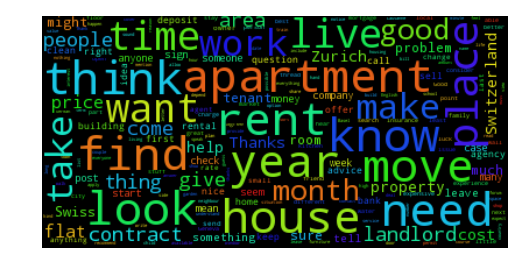

In [17]:
from collections import defaultdict
from nltk.probability import ConditionalFreqDist
from gensim import corpora, models, similarities
from gensim.models import  ldamodel
frequency = defaultdict(int)
# Counting the freq of the words in a topic. (stopwords already done)
print(forumTextContainer.keys())
for thread in forumTextContainer['Housing in general']:
    for token in thread[1]:
        if len(token)>3:
            frequency[token] += 1


# [(k, frequency[k]) for k in sorted(frequency, key=frequency.get, reverse=True)]
words=[(k, frequency[k]) for k in sorted(frequency, key=frequency.get, reverse=True)]
word_c=WordCloud()
wordcloud = WordCloud(max_font_size=40,stopwords=stop).generate_from_frequencies(words)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()



## Topic modeling for threads

In [164]:
pp=pprint.PrettyPrinter(compact=1)
frequency = defaultdict(int)
# Here, we will count the frequency of the words in all the topic
for thread in forumTextContainer['Education']:
    for token in thread[1]:
        if len(token)>3:
            frequency[token] += 1
# Now, we will remove words that have a small value of freq compared with the length of the thread.
# We also organize our tokens in a list per thread
texts = [[token for token in threads[1] if frequency[token]> math.ceil(len(threads[1])/15)] # The really huge topics are reduced
         for threads in forumTextContainer['Education']]

dictionary = corpora.Dictionary(texts)
print(dictionary)
corpus = [dictionary.doc2bow(text) for text in texts]
tfidf = models.TfidfModel(corpus, normalize=True)
corpus_tfidf = tfidf[corpus]
print("Number of threads: %d"%len(corpus))

Dictionary(3356 unique tokens: ['Teacher', 'global', 'lack', 'collect', 'Source']...)
Number of threads 1334


In [162]:
lsi = models.LsiModel(corpus_tfidf,id2word=dictionary, num_topics=10)

topics=[" ".join(re.findall("\"[a-z]+\"",topic[1])) for topic in lsi.print_topics(10,20)]
[(print("topic %d: %s \n" %(i,topic)) ) for (i,topic) in enumerate(topics)]


topic 0: "school" "child" "teacher" "year" "language" "class" "local" "system" "parent" "work" "learn" "time" "make" "speak" "move" "start" 

topic 1: "child" "degree" "study" "university" "school" "course" "master" "student" "program" "bachelor" "teacher" "kindergarten" "apply" "parent" "local" "exam" "daughter" "admission" 

topic 2: "teacher" "language" "kindergarten" "teach" "daycare" "level" "care" "learn" "childcare" "system" "subject" "speak" "week" "nursery" "exam" "class" 

topic 3: "teacher" "school" "international" "public" "book" "class" "kindergarten" "bilingual" "local" "week" "time" "move" "parent" "private" 

topic 4: "language" "school" "speak" "child" "parent" "english" "student" "course" "system" "nursery" "bilingual" "book" "teacher" "education" "kindergarten" "grade" 

topic 5: "teacher" "teach" "kindergarten" "grade" "year" "book" "permit" "start" "date" "university" "anyone" "apprenticeship" 

topic 6: "exam" "book" "test" "grade" "degree" "permit" "math" "work" 

[None, None, None, None, None, None, None, None, None, None]

## Searching Queries
We will use the lsi Vector Space Model algorithms because performs better than Tf-Idf and works enough fast.

In [172]:
new_doc = "Study at the university EPFL in Lausanne with master thesis"
new_vec = dictionary.doc2bow(new_doc.lower().split())
# # index = similarities.SparseMatrixSimilarity(tfidf[corpus], num_features=12)
# index = similarities.Similarity('/tmp/tst', corpus, num_features=12)
vec_lsi = lsi[new_vec] # convert the query to LSI space
index = similarities.MatrixSimilarity(lsi[corpus]) # transform corpus to LSI space and index it
sims = index[vec_lsi] # perform a similarity query against the corpus
sims = sorted(enumerate(sims), key=lambda item: -item[1])
[(print("Thread: %s --> %s \n" %(forumTextContainer['Education'][search[0]][0],search)) ) for search in sims[:10]]

Thread: phd in switzerland --> (745, 0.94093746) 

Thread: Best Universities for PhD in Switzerland --> (1087, 0.9181295) 

Thread: Spanish studies convalidation --> (896, 0.91383064) 

Thread: extra Bachelor courses to foreign nationals --> (681, 0.90699518) 

Thread: MSc in Computer Science at ETH, UZH or EPFL --> (123, 0.90079981) 

Thread: Admission to PhD external thesis project --> (877, 0.8969689) 

Thread: Conditional acceptance to HEC Lausanne --> (785, 0.89367932) 

Thread: Ending my degree in Switzerland --> (705, 0.87141275) 

Thread: Swiss Master's Degree in the US --> (916, 0.87116855) 

Thread: Can anyone recommend me a place to catch up on university-level classes in Zurich? --> (527, 0.86608928) 



[None, None, None, None, None, None, None, None, None, None]

In [173]:
# Extra
# cfdist = ConditionalFreqDist((len(word), word) for word in forumTextContainer['Education'][0][1])
# a=cfdist
# cfdistmax=[]
# cfdistmax=cfdistmax+([(cfdist[index-1].most_common())for index,words in enumerate(cfdist) if index > 3  ])
# len(texts[4])

In [183]:
text_tk = nltk.word_tokenize(strForum) 
word_tag_fd = nltk.pos_tag(text_tk,tagset='universal') # for simplifying the task, we will une the universal tagset
allwords=[wt[0] for wt in word_tag_fd if  wt[0] not in stop]
word_c=WordCloud()
wordcloud = WordCloud(max_font_size=40,stopwords=stop).generate(pd.Series(allwords).str.cat(sep=' '))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

# def comments(thread):
#     # Scrape the HTML at the url
#     response = requests.get(thread,headers={'Accept':'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8'})
#     # Turn the HTML into a Beautiful Soup object
#     soup = BeautifulSoup(response.text, 'lxml')
#     comments={}
#     for link in soup.find_all("div",{"align":"center"}):
#         for link2 in link.find_all("div",{"align":"left"}):
#             for link3 in link2.find_all("tr"):
#                 for link4 in link3.find_all("td",{"width":"99%"}):
#                     for link5 in link4.find_all("div"):
#                         if('id' in link5.attrs and link5['id'].startswith('post_message')):
# #                             print(link5.attrs,link5.contents[0])
#                             contents=''
#                             for content in link5.contents:
#                                 if type(content) is not Tag:
#                                     contents+=' '+content
#                             comments[link5['id']]=contents
# #     print(comments)
#     return ''.join(comments.values())
# comments('http://www.englishforum.ch/education/263961-need-your-help.html')
# findAllPostPages('http://www.englishforum.ch/social-events/25899-poker-thread.html')
# findAllPostPages('http://www.englishforum.ch/education/263961-need-your-help.html')


NameError: name 'nltk' is not defined

In [139]:
# comments(0,'http://www.englishforum.ch/business-entrepreneur/9916-help-businesses-freelancers-ch.html')
# comments(0,'http://www.englishforum.ch/education/49382-childcare-schooling-switzerland.html')
comments(0,'http://www.englishforum.ch/education/264519-information-event-english-about-choosing-career-apprenticeship-search.html')

['   Do you have a son or a daughter at the age 13-16?       The Career Information Centers of the Canton of Zurich offer Information events in English about choosing a career and apprenticeship search.          When:          Wednesday, 25 January 2017, 19.00\x9621.00    Where:        biz Urdorf, In der Luberzen 42, 8902 Urdorf    Please register at www.berufsberatung.zh.ch/integras. \nWe look forward to welcoming you.      ',
 {'date': 'Yesterday, 17:53',
  'exp': 'Newbie',
  'groaned': 'Thanked 0 Times in 0 Posts',
  'location': 'Location: Urdorf',
  'post': '   Do you have a son or a daughter at the age 13-16?       The Career Information Centers of the Canton of Zurich offer Information events in English about choosing a career and apprenticeship search.          When:          Wednesday, 25 January 2017, 19.00\x9621.00    Where:        biz Urdorf, In der Luberzen 42, 8902 Urdorf    Please register at www.berufsberatung.zh.ch/integras. \nWe look forward to welcoming you.      ',
 